In [2]:
!pip install adabelief-tf

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from os import walk
import h5py
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from adabelief_tf import AdaBeliefOptimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from os import walk
from skimage.transform import resize
from PIL import Image
import cv2
import functools

In [5]:
sys.path.append('/content/gdrive/My Drive/Thesis')
TRAIN_PATH = 'training/'

In [5]:
#Have to do it only once

#copy training data to colab, might need to change your path here
!cp -r /content/gdrive/My\ Drive/ColabNotebooks/ANTWERP/training /content 

#unzip training data into the training_data folder


In [6]:
MODEL_SAVE_PATH = 'antwerp_full_data.h5'
IMAGE_WIDTH = 436
IMAGE_HEIGHT = 495

SCALE = True
IMAGE_WIDTH_SCALED = 200
IMAGE_HEIGHT_SCALED = 200
NUMBER_OF_CHANNELS = 2
TIMESTEPS_X = 13
TIMESTEPS_Y = 3

BATCH_SIZE = 3

X_Seq = TIMESTEPS_X * NUMBER_OF_CHANNELS
Y_Seq = TIMESTEPS_Y * NUMBER_OF_CHANNELS

In [7]:
def get_filenames(path):
    for (dirpath, dirnames, filenames) in walk(path):
        return filenames
    
class generator:
    def __call__(self, file):
        with h5py.File(file, 'r') as hf:
            #get the data
            a_group_key = list(hf.keys())[0]
            data = list(hf[a_group_key])

            # transform to appropriate numpy array 
            data = data[0:]
            data = np.stack(data, axis=0)

            yield data_preprocessing(data)

In [8]:
def data_preprocessing(data):

    #combine dimensions of 288 and 8 as in the CNN paper
    def combine_dims(a, i=0, n=1):
      """
      Combines dimensions of numpy array `a`, 
      starting at index `i`,
      and combining `n` dimensions
      """
      s = list(a.shape)
      combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
      return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

    
    #concatenate volume channels into one:
    def scale_channels_and_size(data):
        new_data = []
        
        for img in data:
            img = cv2.resize(img, (IMAGE_HEIGHT_SCALED, IMAGE_WIDTH_SCALED), Image.ANTIALIAS)
            speed_avg = (img[:, :, 0] + img[:, :, 2] + img[:, :, 4] + img[:, :, 6]) / 4.0
            volume_avg = (img[:, :, 1] + img[:, :, 3] + img[:, :, 5] + img[:, :, 7]) / 4.0
            new_data.append(np.array([speed_avg, volume_avg]))
        return np.array(new_data)

    

    
    #load the data and split it into 13:3 chunks
    data = scale_channels_and_size(data)
    data = combine_dims(data, 0) # combines dimension 0 and 1
        
    x = []
    y = []
    
    for i in range(18):
        start = np.random.randint(0, len(data)-(X_Seq+Y_Seq))
        x.append(np.asarray(data[start:start+X_Seq]))
        y.append(np.asarray(data[start+X_Seq:start+(X_Seq+Y_Seq)]))
    
    #divide the data by 255 and take square root
    x = np.array(x)
    y = np.array(y)
    x = np.moveaxis(x, 1, -1)
    y = np.moveaxis(y, 1, -1)
    x = x / 255.
    x = np.sqrt(x)
    y = y / 255.
    y = np.sqrt(y)
    
    return x, y


In [9]:
filenames = get_filenames(TRAIN_PATH)
ds = tf.data.Dataset.from_tensor_slices(filenames)

ds = ds.interleave(lambda filename: tf.data.Dataset.from_generator(
        generator(),
    (np.float32, np.float32),       
    args=(TRAIN_PATH + filename,)))



    


Instructions for updating:
Use output_signature instead


In [10]:
#split into train and validation sets

 

train_size = int(len(filenames)-1)
val_size = int(0.01 * len(filenames))

 

full_dataset = ds.shuffle(100, reshuffle_each_iteration=False)
train_dataset = ds.take(train_size)
val_dataset = ds.skip(train_size)

In [11]:
"""Deep Learning"""

import tensorflow
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import ZeroPadding2D, Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

 

def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    KERNELS_INPUT = X_Seq    
    KERNELS_OUT = Y_Seq

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
 

     #Contraction path
    c1 = Conv2D(KERNELS_INPUT, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(KERNELS_INPUT, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(KERNELS_INPUT*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(KERNELS_INPUT*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
     
    c3 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
     
    c4 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
     
    c5 = Conv2D(KERNELS_INPUT*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(KERNELS_INPUT*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(KERNELS_INPUT*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = ZeroPadding2D(((1, 0), (1, 0)))(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(KERNELS_INPUT*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(KERNELS_INPUT*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(KERNELS_INPUT*4, (2, 2), strides=(2, 2), padding='same')(c6)
    #u7 = ZeroPadding2D(((1, 0), (1, 0)))(u7)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(KERNELS_INPUT*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(KERNELS_INPUT*4, (2, 2), strides=(2, 2), padding='same')(c7)
    
    #u8 = ZeroPadding2D(((1, 0), (0, 0)))(u8)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(KERNELS_INPUT*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(KERNELS_INPUT*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(KERNELS_INPUT*2, (2, 2), strides=(2, 2), padding='same')(c8)
    
    #u9 = ZeroPadding2D(((1, 0), (0, 0)))(u9)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(KERNELS_OUT, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(KERNELS_OUT, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(KERNELS_OUT, (3, 3), activation='relu')(c9)
     
    model = Model(inputs=[inputs], outputs=[c9])
    model.compile(loss='mse',
                  optimizer = AdaBeliefOptimizer(learning_rate = 1e-2, 
                                                 print_change_log = False),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    model.summary()    
    return model

In [12]:
#if SCALE:
model = unet_model(IMAGE_HEIGHT_SCALED, IMAGE_WIDTH_SCALED, 26)
#else:
	#model = unet_model(IMAGE_HEIGHT, IMAGE_WIDTH, 104)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 26 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 26) 6110        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 200, 26) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 26) 6110        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='mean_squared_error', verbose=1, patience=2, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    save_weights_only=True,
    save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=3)

steps = np.int(np.ceil(len(filenames)/BATCH_SIZE))

model.fit(train_dataset, epochs = 20, batch_size = BATCH_SIZE, steps_per_epoch = steps, callbacks = [reduce_lr, model_checkpoint, es])

Epoch 1/20


In [19]:
def open_file(file):
    with h5py.File(file, 'r') as hf:
                #get the data
                a_group_key = list(hf.keys())[0]
                test = list(hf[a_group_key])

 

                # transform to appropriate numpy array 
                test = test[0:]
                test = np.stack(test, axis=0)
                return test

test = open_file('training/2020-06-23_ANTWERP_8ch.h5')
test = data_preprocessing(test)
prediction = model.predict(test[0])
print(prediction)
print(prediction.shape)

[[[[0.         0.         0.         0.         0.         0.        ]
   [0.00340499 0.         0.00492229 0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.        ]
   ...
   [0.         0.         0.         0.         0.         0.        ]
   [0.01128906 0.         0.00900187 0.         0.         0.        ]
   [0.03427325 0.         0.03867371 0.00157558 0.         0.        ]]

  [[0.         0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.        ]
   ...
   [0.         0.         0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.        ]
   [0.03938439 0.         0.04256454 0.         0.         0.        ]]

  [[0.         0.         0.         0.         0.         0.        ]
   [0.01185333 0.         0.01236511 0.         0.         

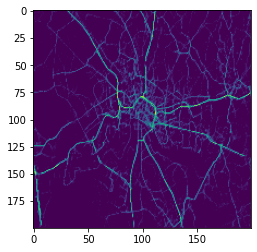

In [26]:
plt.imshow(prediction[0, :, :, 2])

In [ ]:
prediction = model.predict(x[-1:])

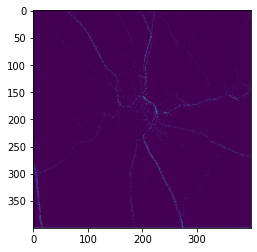

In [ ]:
plt.imshow(prediction[0, :, :, 7]*255.)